## New code

### needed functions

In [1]:
%matplotlib widget
import json
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.path import Path
import numpy as np
import matplotlib
from math import atan2
import mpmath as mp

def split_text(text, max_length=50):
    """Splits text into multiple lines with a maximum length."""
    words = text.split()
    lines = []
    current_line = words[0]

    for word in words[1:]:
        if len(current_line) + len(word) + 1 <= max_length:
            current_line += ' ' + word
        else:
            lines.append(current_line)
            current_line = word
    lines.append(current_line)
    return '\n'.join(lines)

def show_tooltip(ax, fig, x, y, text):
    """Creates and displays a tooltip at the given position with the specified text."""
    tooltip_text = ax.text(x, y, split_text(text), ha='left', va='center', fontsize=10, zorder=3, bbox=dict(facecolor='white', alpha=0.8, edgecolor='black'))
    fig.canvas.draw()
    return tooltip_text

def hide_tooltip(tooltip_text, fig):
    """Hides any existing tooltip."""
    if tooltip_text:
        tooltip_text.remove()
        fig.canvas.draw()

def plot_curved_edge(ax, x0, y0, x1, y1, style, weight):
    rad = 0.3  # curvature
    control_x = (x0 + x1 * 2) / 3 + rad * (y1 - y0)
    control_y = (y0 + y1 * 2) / 3 - rad * (x1 - x0)

    bezier_x = [x0, control_x, x1]
    bezier_y = [y0, control_y, y1]

    # Plot curved line
    ax.plot(bezier_x, bezier_y, **style)

    # Plot weight label
    if (x0 == x1 and y0 == y1):
        # place text a little bit higher than the center of the line
        ax.text((x0 + x1 * 2) / 3 + rad * (y1 - y0), (y0 + y1 * 2) / 3 - rad * (x1 - x0) - 0.1, f"{weight:,}", ha='center', va='center', fontsize=8)
    else:
        # Add arrow tip
        arrow_length = 0.03 
        arrow_width = 0.02 * max(1, style.get('linewidth', 1)/2)
        dx = x1 - control_x
        dy = y1 - control_y
        angle = np.arctan2(dy, dx)
        
        ax.arrow(x1 - 3 * arrow_length * np.cos(angle),
                y1 - 3 * arrow_length * np.sin(angle),
                arrow_length * np.cos(angle),
                arrow_length * np.sin(angle),
                head_width=arrow_width, head_length=arrow_length,
                fc=style.get('color', 'k'), ec=style.get('color', 'k'))
        ax.text((x0 + x1 * 2) / 3 + rad * (y1 - y0), (y0 + y1 * 2) / 3 - rad * (x1 - x0), f"{weight:,}", ha='center', va='center', fontsize=8)

def read_data(filepath):
    """Read data from JSON file."""
    with open(filepath) as f:
        data = json.load(f)
        data.pop('time_start', None)
        return data

def create_graph(data):
    """Create a graph from the data."""
    G = nx.DiGraph()
    for thread_id, thread_data in data.items():
        if thread_id == "time_start":
            continue
        G.add_node(thread_id, info=thread_data["overall"])
        for target_thread_id, pairwise_data in thread_data.items():
            if target_thread_id != "overall":
                count_delegate_to_j_items = pairwise_data["count_delegate_to_j_items"]
                G.add_edge(thread_id, target_thread_id, weight=count_delegate_to_j_items, info=pairwise_data)
    return G

def draw_figure(G):
    """Draw the graph."""
    pos = nx.circular_layout(G)
    max_weight = max([edge[2]['weight'] for edge in G.edges(data=True)])

    fig, ax = plt.subplots(figsize=(14, 8))

    # Draw edges
    for edge in G.edges(data=True):
        source, target, data = edge
        weight = data['weight']
        x0, y0 = pos[source]
        x1, y1 = pos[target]
        linewidth = max(weight/max_weight * 5, 0.5)
        style = {'color': 'blue', 'linewidth': linewidth} # if source < target else {'color': 'gray', 'linewidth': linewidth, 'linestyle': 'dashed'}
        plot_curved_edge(ax, x0, y0, x1, y1, style, weight)    

    # Draw nodes
    node_colors = [int(len(G[node])) * 20 for node in G.nodes()]
    for node, info in G.nodes(data=True):
        x, y = pos[node]
        ax.plot(x, y, 'o', markersize=15, markerfacecolor='lightblue', markeredgewidth=2, markeredgecolor='blue')
        ax.text(x, y + 0.1, f"{node}", ha='center', va='center', fontsize=10)

    ax.axis('off')
    ax.set_xlim([min(x for x, _ in pos.values()) - 0.5, max(x for x, _ in pos.values()) + 0.5])
    ax.set_ylim([min(y for _, y in pos.values()) - 0.5, max(y for _, y in pos.values()) + 0.5])

    tooltip_text = [None]  # Use a list to store the tooltip_text reference

    def on_click(event):
        if len(tooltip_text) >= 1:
            hide_tooltip(tooltip_text[0], fig)
            tooltip_text[0] = None
        if event.inaxes:
            # Check for node click
            for node, (x, y) in pos.items():
                if abs(event.xdata - x) < 0.05 and abs(event.ydata - y) < 0.05:
                    info = G.nodes[node]['info']
                    tooltip_text[0] = show_tooltip(ax, fig, event.xdata, event.ydata, f"Node {node}\nInfo: {info}")
                    print(f"Node {node} clicked. Info: {info}")
                    return
            # Check for edge click
            for edge in G.edges(data=True):
                source, target, data = edge
                x0, y0 = pos[source]
                x1, y1 = pos[target]
                rad = 0.3
                control_x = (x0 + x1 * 2) / 3 + rad * (y1 - y0)
                control_y = (y0 + y1 * 2) / 3 - rad * (x1 - x0)
                bezier_x = [x0, control_x, x1]
                bezier_y = [y0, control_y, y1]
                dist = np.hypot(np.array(bezier_x) - event.xdata, np.array(bezier_y) - event.ydata).min()
                if dist < 0.05:
                    info = data['info']
                    tooltip_text[0] = show_tooltip(ax, fig, event.xdata, event.ydata, f"Edge {source} -> {target}\nInfo: {info}")
                    print(f"Edge {source} -> {target} clicked. Info: {info}")
                    return

    fig.canvas.mpl_connect('button_press_event', on_click)
    plt.show()

### main execution

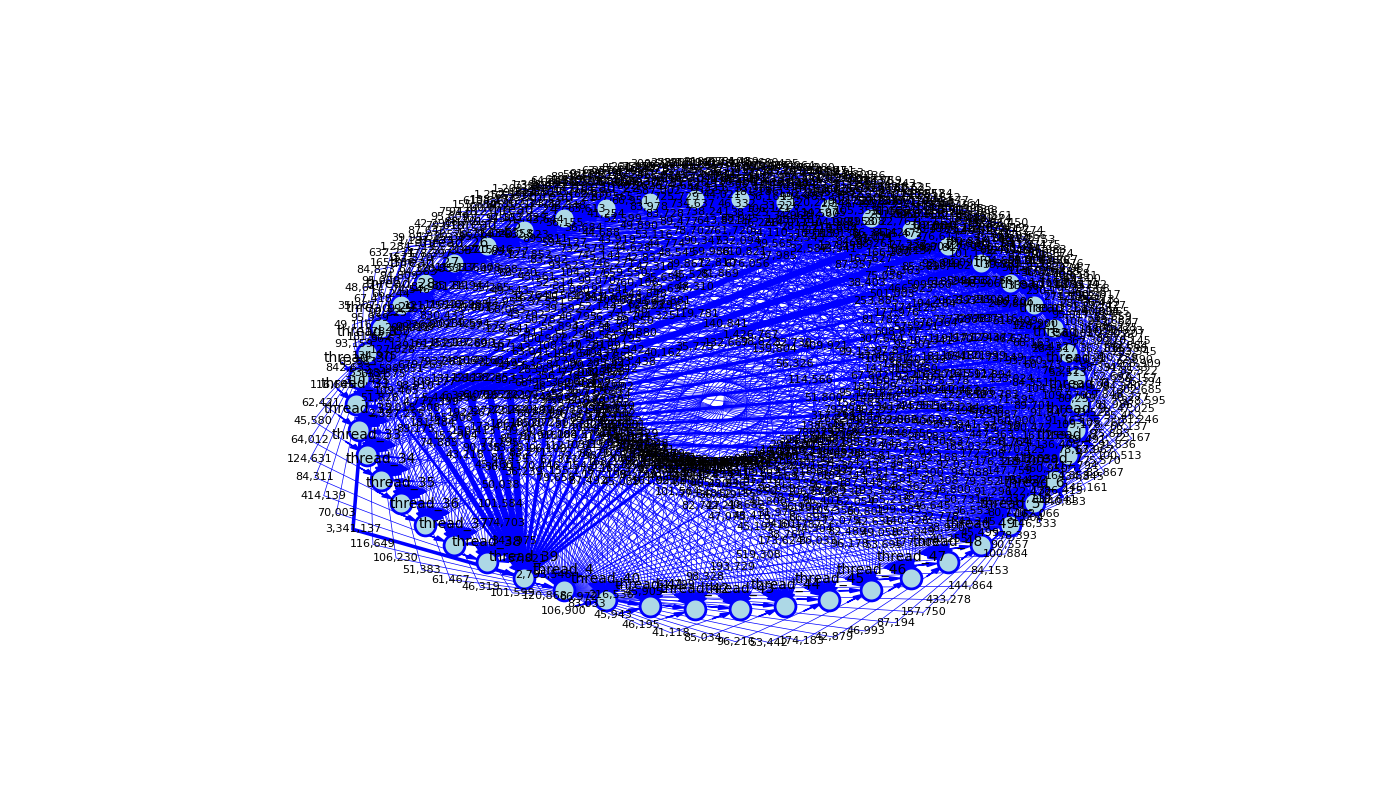

In [5]:
# Main execution

# read data
filepath = '/home/vinh/Q32024/CuckooHeavyKeeper/experiments/stat_ALGORITHM_+2024-08-20_1604.json'
data = read_data(filepath)

# only draw nodes with specific ids
need_to_draw_nodes = [f'thread_{i}' for i in range(20)]
filtered_data = {k: v for k, v in data.items() if k in need_to_draw_nodes}
filtered_data.update({k: {'overall': v['overall']} for k, v in data.items() if k  not in need_to_draw_nodes})

# draw_figure
G = create_graph(filtered_data)
draw_figure(G)